<a href="https://colab.research.google.com/github/Blackcipher101/DeepLearning/blob/master/tranferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [11]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import numpy as np
import PIL.Image as Image

In [10]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

In [6]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteQIVPW1/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [12]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [13]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tabby', 'Siamese cat', 'Persian cat', 'Border collie', 'tabby',
       'tiger cat', 'kelpie', 'redbone', 'Great Dane', 'Persian cat',
       'Egyptian cat', 'groenendael', 'tabby', 'Egyptian cat', 'tabby',
       'Persian cat', 'Airedale', 'bathtub', 'tabby', 'German shepherd',
       'pug', 'Pomeranian', 'tiger cat', 'malinois', 'lynx', 'Pembroke',
       'Saint Bernard', 'tabby', 'laptop', 'tabby', 'Egyptian cat',
       'Siberian husky'], dtype='<U30')

In [18]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [19]:
feature_extractor.trainable = False

In [20]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 57s 98ms/step - loss: 0.0541 - accuracy: 0.9826 - val_loss: 0.0318 - val_accuracy: 0.9893
Epoch 2/6
582/582 [==============================] - 55s 95ms/step - loss: 0.0307 - accuracy: 0.9890 - val_loss: 0.0314 - val_accuracy: 0.9888
Epoch 3/6
582/582 [==============================] - 55s 95ms/step - loss: 0.0258 - accuracy: 0.9907 - val_loss: 0.0316 - val_accuracy: 0.9895
Epoch 4/6
582/582 [==============================] - 55s 95ms/step - loss: 0.0236 - accuracy: 0.9922 - val_loss: 0.0339 - val_accuracy: 0.9903
Epoch 5/6
582/582 [==============================] - 55s 95ms/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.0325 - val_accuracy: 0.9905
Epoch 6/6
582/582 [==============================] - 55s 95ms/step - loss: 0.0172 - accuracy: 0.9946 - val_loss: 0.0366 - val_accuracy: 0.9901


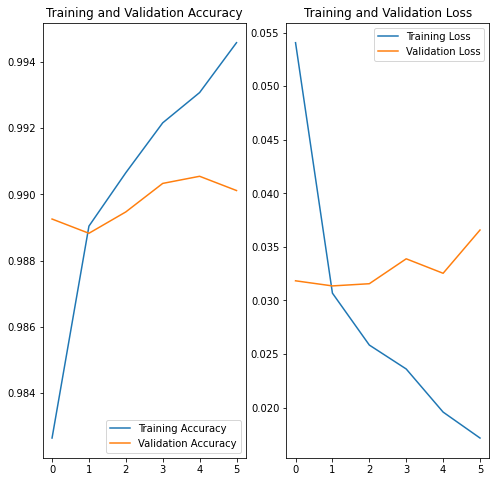

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [24]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog',
       'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat',
       'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog',
       'cat', 'cat', 'cat', 'cat', 'dog'], dtype='<U3')

In [25]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1]
Predicted labels:  [0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1]


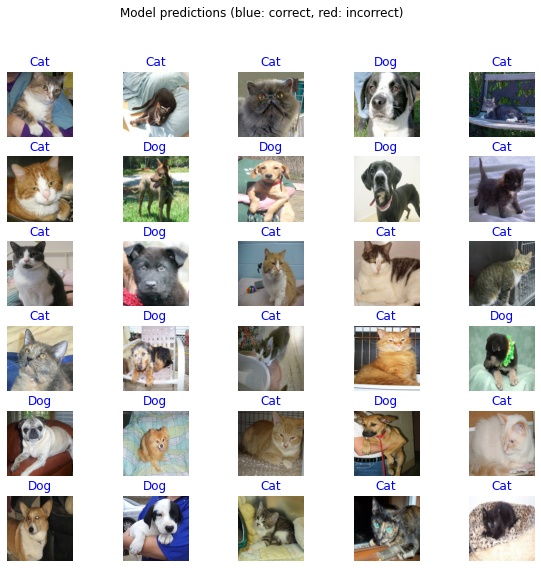

In [26]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")